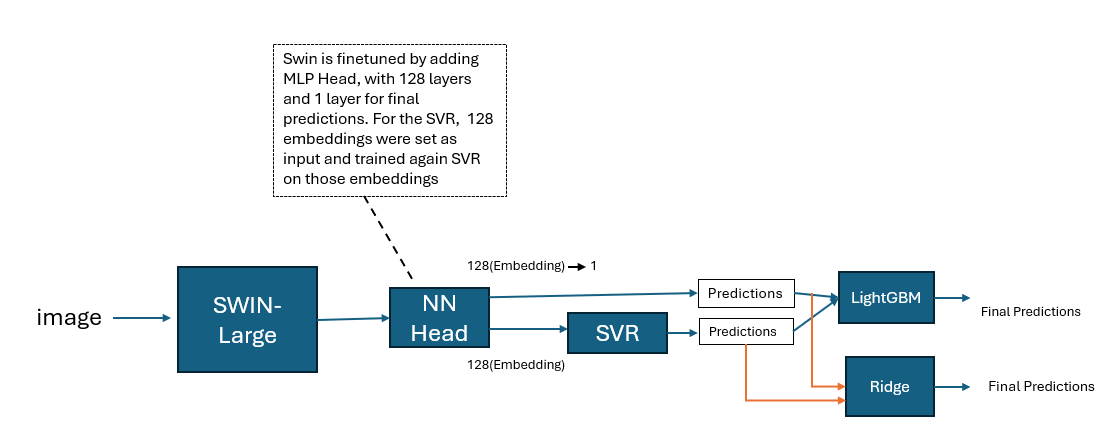
### Overview

In this approach, a Swin-Large backbone pretrained on ImageNet is used to extract embeddings from pet images. A Neural Network (MLP) Head is added on top with 128 embedding dimensions and 1 output for final predictions. Additionally, the same 128-dimensional embeddings are used as input to a Support Vector Regressor (SVR), producing a separate prediction. Both predictions are then combined using a LightGBM model to produce the final output. However the results are not better than single model.This is because the SVR predictions are not helping the model to learn as it did not performed well here. which makes the stacking less useful and overall results are not improved








In [ ]:


import os, json, time, random, shutil, gc
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import timm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

def rmse_score(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

print("Torch", torch.__version__, "| CUDA:", torch.cuda.is_available())


Torch 2.6.0+cu124 | CUDA: True


In [ ]:
class CFG:
    train_csv = "src/inputs/train.csv"
    train_imgdir = "src/inputs/train"
    test_csv = "src/inputs/test.csv"
    test_imgdir = "src/inputs/test"
    sample_submission = "src/inputs/sample_submission.csv"
    outdir = "outputs"
    model_name = "swin_large_patch4_window12_384.ms_in22k"  # Swin-L 
    img_size = 384
    folds = 5
    epochs = 10
    patience = 5
    batch_size = 8
    lr = 2e-5
    weight_decay = 1e-4
    seed = 42
    tta = 1  

set_seed(CFG.seed)
os.makedirs(CFG.outdir, exist_ok=True)

# Load data FIRST (train with targets, test without)
df = pd.read_csv(CFG.train_csv)
test_df = pd.read_csv(CFG.test_csv)

# Ensure test has no target column
if "Pawpularity" in test_df.columns:
    test_df = test_df.drop(columns=["Pawpularity"])



# Stratify bins on train only
df["_bin"] = pd.cut(df["Pawpularity"], bins=10, labels=False)

print("Train/Test shapes:", df.shape, test_df.shape)


Train/Test shapes: (9912, 15) (8, 13)


In [ ]:
class PawDataset(Dataset):
    def __init__(self, df, img_dir, img_size=384, is_train=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.is_train = is_train
        if is_train:
           
            self.transform = T.Compose([
                T.RandomResizedCrop(img_size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                T.ToTensor(),
                T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])
        else:
            self.transform = T.Compose([
                T.Resize(int(img_size*1.15)),
                T.CenterCrop(img_size),
                T.ToTensor(),
                T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["Id"]
        img = Image.open(self.img_dir / f"{img_id}.jpg").convert("RGB")
        img = self.transform(img)
        y = row["Pawpularity"] if "Pawpularity" in row.index else np.nan
        y_norm = np.float32(y / 100.0) if not np.isnan(y) else np.nan
        return {"image": img, "id": img_id, "target_norm": y_norm}


In [ ]:
class SwinBackboneHead(nn.Module):
    def __init__(self, model_name="swin_large_patch4_window12_384.ms_in22k", emb_dim=128, pretrained=True):
        super().__init__()
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        in_features = self.backbone.num_features
        self.emb = nn.Linear(in_features, emb_dim)
        self.head = nn.Linear(emb_dim, 1)  # BCE logit

    def forward(self, x, return_embedding=False):
        feats = self.backbone(x)           # (B, in_features)
        emb = F.relu(self.emb(feats), inplace=True)  # (B, 128)
        logit = self.head(emb).squeeze(1)            # (B,)
        if return_embedding:
            return logit, emb
        return logit


In [ ]:
def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    losses = []
    
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["target_norm"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=True):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        del x, y, logits, loss
        torch.cuda.empty_cache()
    return float(np.mean(losses))

def validate_epoch(model, loader, device):
    model.eval()
    preds, gts = [], []
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["target_norm"].numpy()
        logits = model(x)
        prob = torch.sigmoid(logits).detach().cpu().numpy() * 100.0
        preds.append(prob); gts.append(y * 100.0)
        del x, logits
        torch.cuda.empty_cache()
    preds = np.concatenate(preds); gts = np.concatenate(gts)
    return rmse_score(gts, preds)

def extract_embeddings(model, loader, device):
    model.eval()
    ids, embs, preds_mlp = [], [], []
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        logits, emb = model(x, return_embedding=True)
        prob = torch.sigmoid(logits).detach().cpu().numpy() * 100.0
        embs.append(emb.detach().cpu().numpy())
        preds_mlp.append(prob)
        ids.extend(batch["id"])
        del x, logits, emb
        torch.cuda.empty_cache()
    return ids, np.concatenate(embs), np.concatenate(preds_mlp)

def predict_tta_from_tensors(model, images_tensor, device, tta=1, img_size=384):
    model.eval()
    if tta <= 1:
        logits = model(images_tensor.to(device, non_blocking=True))
        prob = torch.sigmoid(logits).detach().cpu().numpy() * 100.0
        del logits
        torch.cuda.empty_cache()
        return prob
    b = images_tensor.size(0)
    base_norm = T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    probs = []
    for _ in range(tta):
        tta_transform = T.Compose([
            T.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
            T.RandomHorizontalFlip(p=0.5),
            T.ToTensor(),
            base_norm
        ])
        imgs = []
        for i in range(b):
            pil = T.ToPILImage()(images_tensor[i].cpu())
            imgs.append(tta_transform(pil))
        xt = torch.stack(imgs, dim=0).to(device, non_blocking=True)
        logits = model(xt)
        probs.append(torch.sigmoid(logits).detach().cpu().numpy() * 100.0)
        del xt, logits
        torch.cuda.empty_cache()
    return np.stack(probs, axis=0).mean(axis=0)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

oof_rows = []
test_preds_folds = []
fold_summaries = {}

for fold, (tr_idx, va_idx) in enumerate(skf.split(df, df["_bin"])):
    print(f"\n========== Fold {fold} ==========")
    fold_dir = Path(CFG.outdir) / f"fold{fold}"
    if fold_dir.exists():
        shutil.rmtree(fold_dir)
    fold_dir.mkdir(parents=True, exist_ok=True)

    tr_df = df.iloc[tr_idx].copy().reset_index(drop=True)
    va_df = df.iloc[va_idx].copy().reset_index(drop=True)

    train_ds = PawDataset(tr_df, CFG.train_imgdir, img_size=CFG.img_size, is_train=True)
    valid_ds = PawDataset(va_df, CFG.train_imgdir, img_size=CFG.img_size, is_train=False)
    test_ds  = PawDataset(test_df.assign(Pawpularity=np.nan), CFG.test_imgdir, img_size=CFG.img_size, is_train=False)

    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model = SwinBackboneHead(model_name=CFG.model_name, emb_dim=128, pretrained=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scaler = torch.amp.GradScaler(device="cuda", enabled=True)

    best_rmse = float("inf")
    best_path = fold_dir / "best.pt"
    patience_count = 0

    for epoch in range(1, CFG.epochs + 1):
        t0 = time.time()
        tr_loss = train_one_epoch(model, train_loader, optimizer, scaler, device)
        va_rmse = validate_epoch(model, valid_loader, device)
        print(f"Fold {fold} | Epoch {epoch} | Train loss {tr_loss:.4f} | Val RMSE {va_rmse:.4f} | {time.time()-t0:.1f}s")
        if va_rmse < best_rmse - 1e-4:
            best_rmse = va_rmse
            patience_count = 0
            torch.save({"state_dict": model.state_dict(), "rmse": best_rmse}, best_path)
        else:
            patience_count += 1
            if patience_count >= CFG.patience:
                print(f"Early stopping at epoch {epoch}, best RMSE {best_rmse:.4f}")
                break
        torch.cuda.empty_cache()

    # Load best and free optimizer state
    ckpt = torch.load(best_path, map_location="cpu")
    model.load_state_dict(ckpt["state_dict"])
    del optimizer, scaler, ckpt
    gc.collect(); torch.cuda.empty_cache()

    # Extract embeddings and MLP preds
    va_ids, va_embs, va_mlp = extract_embeddings(model, valid_loader, device)
    te_ids, te_embs, te_mlp = extract_embeddings(model, test_loader, device)
    tr_ids, tr_embs, tr_mlp = extract_embeddings(model, train_loader, device)

    # Train SVR on train embeddings (targets in 1..100)
    svr = Pipeline([("scaler", StandardScaler()), ("svr", SVR(C=10.0, epsilon=0.2, kernel="rbf"))])
    y_tr = tr_df["Pawpularity"].values.astype(np.float32)
    svr.fit(tr_embs, y_tr)

    # Predict SVR
    va_svr = svr.predict(va_embs).astype(np.float32)
    te_svr = svr.predict(te_embs).astype(np.float32)

    # Ensemble per fold
    va_ens = (va_mlp + va_svr) / 2.0
    te_ens = (te_mlp + te_svr) / 2.0

    # OOF rows
    for i, vid in enumerate(va_ids):
        oof_rows.append({
            "Id": vid,
            "fold": fold,
            "y_true": float(va_df.loc[va_df["Id"] == vid, "Pawpularity"].values[0]),
            "pred_mlp": float(va_mlp[i]),
            "pred_svr": float(va_svr[i]),
            "pred_ens": float(va_ens[i]),
        })

    # Save artifacts
    np.save(fold_dir / "val_embeddings.npy", va_embs)
    np.save(fold_dir / "train_embeddings.npy", tr_embs)
    np.save(fold_dir / "test_embeddings.npy", te_embs)
    np.save(fold_dir / "val_pred_mlp.npy", va_mlp)
    np.save(fold_dir / "val_pred_svr.npy", va_svr)
    np.save(fold_dir / "val_pred_ens.npy", va_ens)
    np.save(fold_dir / "test_pred_mlp.npy", te_mlp)
    np.save(fold_dir / "test_pred_svr.npy", te_svr)
    np.save(fold_dir / "test_pred_ens.npy", te_ens)
    torch.save(svr, fold_dir / "svr.pkl")

    fold_summaries[f"fold_{fold}"] = {"best_val_rmse": best_rmse, "val_count": len(va_ids), "test_count": len(te_ids)}
    test_preds_folds.append(pd.DataFrame({"Id": te_ids, f"fold{fold}": te_ens}))

    # Cleanup before next fold
    del train_loader, valid_loader, test_loader
    del train_ds, valid_ds, test_ds
    del tr_embs, va_embs, te_embs, tr_mlp, va_mlp, te_mlp, va_svr, te_svr, va_ens, te_ens
    del model, svr
    gc.collect(); torch.cuda.empty_cache()



========== Fold 0 ==========
Fold 0 | Epoch 1 | Train loss 0.6471 | Val RMSE 17.7858 | 488.9s
Fold 0 | Epoch 2 | Train loss 0.6303 | Val RMSE 18.4632 | 467.4s
Fold 0 | Epoch 3 | Train loss 0.6128 | Val RMSE 18.2868 | 473.1s
Fold 0 | Epoch 4 | Train loss 0.5964 | Val RMSE 19.2052 | 340.7s
Fold 0 | Epoch 5 | Train loss 0.5865 | Val RMSE 18.7788 | 318.5s
Fold 0 | Epoch 6 | Train loss 0.5807 | Val RMSE 18.8495 | 318.8s
Early stopping at epoch 6, best RMSE 17.7858

========== Fold 1 ==========
Fold 1 | Epoch 1 | Train loss 0.6462 | Val RMSE 18.3170 | 339.1s
Fold 1 | Epoch 2 | Train loss 0.6310 | Val RMSE 17.8406 | 338.0s
Fold 1 | Epoch 3 | Train loss 0.6144 | Val RMSE 18.0370 | 339.0s
Fold 1 | Epoch 4 | Train loss 0.5976 | Val RMSE 18.5980 | 341.9s
Fold 1 | Epoch 5 | Train loss 0.5872 | Val RMSE 18.9346 | 340.0s
Fold 1 | Epoch 6 | Train loss 0.5813 | Val RMSE 18.9377 | 342.3s
Fold 1 | Epoch 7 | Train loss 0.5788 | Val RMSE 18.8639 | 341.4s
Early stopping at epoch 7, best RMSE 17.8406

====

In [31]:
# OOF and submission
oof_df = pd.DataFrame(oof_rows)
oof_df.to_csv(Path(CFG.outdir) / "oof_predictions.csv", index=False)
oof_rmse = rmse_score(oof_df["y_true"].values, oof_df["pred_ens"].values)
print(f"OOF RMSE (ensemble): {oof_rmse:.4f}")
fold_summaries = {"oof_rmse": oof_rmse, **fold_summaries}
save_json(fold_summaries, Path(CFG.outdir) / "fold_summaries.json")




OOF RMSE (ensemble): 18.6619


## Finding optimal weights for ensemble

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# ================================
# 1. Load OOF file
# ================================
oof_path = Path(CFG.outdir) / "oof_predictions.csv"
oof = pd.read_csv(oof_path)

y_true   = oof["y_true"].values.astype(np.float32)
pred_mlp = oof["pred_mlp"].values.astype(np.float32)
pred_svr = oof["pred_svr"].values.astype(np.float32)

# ================================
# 2. RMSE 
# ================================
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Individual RMSEs
rmse_mlp = rmse(y_true, pred_mlp)
rmse_svr = rmse(y_true, pred_svr)
rmse_avg = rmse(y_true, 0.5 * pred_mlp + 0.5 * pred_svr)

# ================================
# 3. Optimal weight search
# ================================
def find_best_weight(y_true, mlp, svr):
    best_w = 0.0
    best_rmse = 999.0
    
    for w in np.linspace(0, 1, 1001):  # 0.000 → 1.000
        blended = w * mlp + (1 - w) * svr
        r = rmse(y_true, blended)
        if r < best_rmse:
            best_rmse = r
            best_w = w
    
    return best_w, best_rmse

best_w, best_rmse = find_best_weight(y_true, pred_mlp, pred_svr)

# ================================
# 4. Print all results
# ================================
print("=======================================")
print("           OOF RMSE RESULTS")
print("=======================================")
print(f" MLP only RMSE              : {rmse_mlp:.6f}")
print(f" SVR only RMSE              : {rmse_svr:.6f}")
print(f" Simple Average (0.5/0.5)   : {rmse_avg:.6f}")
print("---------------------------------------")
print(f" Optimal Blend Weight (MLP) : {best_w:.4f}")
print(f" Optimal Blend RMSE         : {best_rmse:.6f}")
print("=======================================")


           OOF RMSE RESULTS
 MLP only RMSE              : 17.831936
 SVR only RMSE              : 21.334524
 Simple Average (0.5/0.5)   : 18.661909
---------------------------------------
 Optimal Blend Weight (MLP) : 0.9480
 Optimal Blend RMSE         : 17.820177


In [24]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))


# ================================
# Load OOF (with fold column)
# ================================
oof = pd.read_csv("outputs/oof_predictions.csv")

y = oof["y_true"].values.astype(np.float32)
X = np.vstack([
    oof["pred_mlp"].values.astype(np.float32),
    oof["pred_svr"].values.astype(np.float32)
]).T

folds = oof["fold"].values.astype(int)
unique_folds = np.unique(folds)

print("Folds detected:", unique_folds)


# ================================
# Base-model RMSE (valid)
# ================================
pred_mlp = X[:, 0]
pred_svr = X[:, 1]

print("\nBase-model RMSEs (valid, from OOF):")
print("MLP   :", rmse(y, pred_mlp))
print("SVR   :", rmse(y, pred_svr))
print("Avg12 :", rmse(y, 0.5*(pred_mlp + pred_svr)))


# ================================
# LightGBM meta-model (cross-validated)
# ================================
lgb_oof = np.zeros_like(y, dtype=np.float32)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "min_data_in_leaf": 5,
    "seed": 42,
}
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=False)
]

for f in unique_folds:
    tr_idx = np.where(folds != f)[0]
    val_idx = np.where(folds == f)[0]

    dtrain = lgb.Dataset(X[tr_idx], label=y[tr_idx])
    dval   = lgb.Dataset(X[val_idx], label=y[val_idx])

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dval],
        # early_stopping_rounds=50,
        # verbose_eval=False
    )

    lgb_oof[val_idx] = model.predict(X[val_idx], num_iteration=model.best_iteration)


print("\nLightGBM Stacking CV RMSE:", rmse(y, lgb_oof))


# ================================
# Ridge stacking baseline (recommended)
# ================================
ridge_oof = np.zeros_like(y, dtype=np.float32)

for f in unique_folds:
    tr_idx = np.where(folds != f)[0]
    val_idx = np.where(folds == f)[0]

    model = Ridge(alpha=1.0)
    model.fit(X[tr_idx], y[tr_idx])
    ridge_oof[val_idx] = model.predict(X[val_idx])

print("Ridge Stacking CV RMSE   :", rmse(y, ridge_oof))


# ================================
# FINAL META-MODEL (train on full OOF)
# ================================
dtrain_full = lgb.Dataset(X, label=y)
final_meta_model = lgb.train(params, dtrain_full, num_boost_round=2000)



Folds detected: [0 1 2 3 4]

Base-model RMSEs (valid, from OOF):
MLP   : 17.831934983995357
SVR   : 21.334524280366114
Avg12 : 18.6619089512066

LightGBM Stacking CV RMSE: 19.11579783337961
Ridge Stacking CV RMSE   : 17.853491587508433
